In [2]:
from math import pi
import numpy as np
import gzip
from scipy.stats import multivariate_normal
import time

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Problem 1: 
# find $\sigma$ such that $E(\|x\|)=d$, where $x\sim \mathcal{N}(\vec 0, \sigma^2 I_n)$

The theoretical solution is given by the expression:

$$ E(\|x\|) = \sigma \sqrt{2} \frac{\Gamma((n+1)/2)}{\Gamma(n/2)}$$

See for example: see https://stats.stackexchange.com/questions/144893/what-is-the-expected-norm-mathbb-e-lvert-x-rvert-for-a-multivariate-normal

Therefore, for $E(\|x\|)=d$ and $n=3$ we have the following calculation of $\sigma$:

$$\sigma = \frac{\Gamma(3/2)}{\sqrt{2}}d = \frac{\sqrt{\pi}}{2\sqrt{2}}d$$

In [3]:
def get_sigma_square(d):
    return d ** 2 * pi / 8

def get_spherical_gaussian(d):
    mu = [0., 0., 0.]
    sigma_square = get_sigma_square(d)
    cov = [[sigma_square, 0., 0.], [0., sigma_square, 0.], [0., 0., sigma_square]]
    return multivariate_normal(mu, cov)

In [4]:
# Sanity check

pae = 5  # input distance
k = 100000  # number of randomizations
eps = 1e-2  # tolerance

dist = get_spherical_gaussian(pae)
distances = [np.sqrt(np.dot(x,x)) for x in dist.rvs(size=k)]
assert(abs(np.mean(distances) - pae) < eps)

# Problem 2:
# compute the probability mass of $\mathcal{N}(\vec 0, \sigma^2 I_n)$ restricted to the sphere 
# $$S=\{y\in\mathbb{R}^3\;|\; \|y-c\|^2 < r^2\}$$

In [5]:
pae = 7  # input PAE
c = 4  # distance between residues
r = 10  # contact threshold in Angstroms 
k = 100000  # number of randomizations

center = np.array([c, 0., 0.])
dist = get_spherical_gaussian(pae)

contact_prob = np.mean([int(np.dot(y-center, y-center) < r**2) for y in dist.rvs(size=k)])
contact_prob

0.74452

# Wrap up:

# How to compute the contact probability with these scripts?

Given residues C and R, with C being the center of the contact volume:

1) d = PAE(R, C) -- the one that evaluates the expected error on R if we align at C, provided by AlphaFold

2) r = contact volume radius about C -- typically 10Å in our setting

3) c = estimate of the distance between R and C -- provided by AlphaFold

The contact probability, according to the spherical Gaussian model, can be computed with the following function:

In [6]:
def contact_probability(d, r, c, k=10000):

    center = np.array([c, 0., 0.])
    dist = get_spherical_gaussian(d)
    return np.mean([int(np.dot(y-center, y-center) < r**2) for y in dist.rvs(size=k)])

In [7]:
d = 10
r = 10
c = 8

contact_probability(d, r, c)

0.3349

# Test

In [8]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from Bio.PDB.PDBParser import PDBParser
from scipy.stats import pearsonr
import sys

sys.path.append('../../')
from global_variables import WORKSPACE

In [9]:
# Functions to compute the probability of contact

def cap(r, h):
    """
    Volume of the polar cap of the sphere with radius r and cap height h
    """
    return pi * (3 * r - h) * h ** 2 / 3


def vol(r):
    """
    Volume of sphere with radius r
    """
    return 4 * pi * r ** 3 / 3


def s2_minus_s1(r1, r2, d):

    """
    Volume of S2 outside of S1
    r1: radius of S1
    r2: radius of S2
    d: distance between center of S1 and center of S2
    """

    # S1 and S2 not in contact
    if d > r1 + r2:
        return vol(r2)

    # S1 sits inside S2
    elif (r2 > d + r1):
        return vol(r2) - vol(r1)

    # S2 sits inside S1
    elif (r1 > d + r2):
        return 0.

    # Center of S2 is outside S1
    elif d > r1:
        h1 = (r2 ** 2 - (d - r1) ** 2) / (2 * d)
        h2 = r1 - h1 + r2 - d
        return vol(r2) - cap(r1, h1) - cap(r2, h2)

    # Center of S2 is inside S1
    elif d <= r1:
        h1 = (r2 ** 2 - (r1 - d) ** 2) / (2 * d)
        h2 = d - r1 + h1 + r2
        return cap(r2, h2) - cap(r1, h1)

In [10]:
# Other functions

def get_structure(file):
    """
    Use Bio.PDB to parse protein structure.
    """

    id = file.split("AF-")[1].split("-model_v1")[0]

    if file.endswith('.gz'):
        with gzip.open(file, 'rt') as handle:
            return PDBParser().get_structure(id=id, file=handle)[0]
    else:
        with open(file, 'r') as handle:
            return PDBParser().get_structure(id=id, file=handle)[0]


def get_dist_matrix(chain) :
    """
    Compute the distance matrix between C-alpha of a protein.
    """

    m = np.zeros((len(chain), len(chain)), float)

    for i, res1 in enumerate(chain) :
        for j, res2 in enumerate(chain) :
            m[i, j] = abs(res1["CA"] - res2["CA"])

    return m


def get_contact_map(chain, distance=10):
    """
    Compute the contact map between C-alpha of a protein.
    """

    dist_matrix = get_dist_matrix(chain)

    return dist_matrix < distance


def get_prob_contact(pae_value, dmap_value, distance=10):
    """
    Get probability of contact considering the distance
    between residues in the predicted structure and the
    Predicted Aligned Error (PAE).
    """

    if pae_value == 0:

        if dmap_value < distance:
            return 1
        else:
            return 0

    else:
        # Get the volume of res2 outside of res1
        vol_s2_out_s1 = s2_minus_s1(r1=distance, r2=pae_value, d=dmap_value)

        # Get the probability that s2 is out of s1
        p_s2_in_s1 = vol_s2_out_s1 / vol(pae_value)

        return 1 - p_s2_in_s1


def get_prob_cmap(chain, pae, distance=10) :
    """
    Compute the probabilities that each pair of residue in a protein are
    in contact taking into account the Predicted Aligned Error (PAE) and
    the PDB structure predicted by AlphaFold 2
    """

    m = np.zeros((len(chain), len(chain)), float)

    for i, res1 in enumerate(chain):
        for j, res2 in enumerate(chain):
            d = abs(res1["CA"] - res2["CA"])
            m[i, j] = get_prob_contact(pae[i, j], d, distance)

    return m

In [22]:
# New method and comparison

def get_prob_cmap_alt(chain, pae, distance=10) :
    """
    Compute the probabilities that each pair of residue in a protein are
    in contact taking into account the Predicted Aligned Error (PAE) and
    the PDB structure predicted by AlphaFold 2
    """

    m = np.zeros((len(chain), len(chain)), float)

    for i, res1 in enumerate(tqdm(chain, desc="Residue i")):
        for j, res2 in enumerate(chain):
            d = abs(res1["CA"] - res2["CA"])
            m[i, j] = 1 if i == j else contact_probability(pae[i, j], distance, d)

    return m


def compare_pcmaps(gene, seq_df, dataset_dir):
    """
    Compute cmaps in two alternative approaches and Person 
    correlation between the resulting matrices.
    """
    
    uni_id = seq_df[seq_df["Gene"] == gene].Uniprot_ID.values[0]
    pdb_path = f"{pdb_dir}/AF-{uni_id}-F1-model_v4.pdb"
    pae_path = f"{pae_dir}/{uni_id}-F1-predicted_aligned_error.npy"
    
    pdb = get_structure(pdb_path)["A"]
    pae = np.load(pae_path)
    
    t0 = time.perf_counter()
    pcmap = get_prob_cmap(pdb, pae)
    t1 = time.perf_counter()
    elapsed_min = (t1 - t0) / 60.0
    print(elapsed_min)
    
    t0 = time.perf_counter()
    pcmap_alt = get_prob_cmap_alt(pdb, pae)
    t1 = time.perf_counter()
    elapsed_min = (t1 - t0) / 60.0
    print(elapsed_min)

    corr, pval = pearsonr(pcmap.flatten(), pcmap_alt.flatten())
    print(f"Pearson correlation: {corr:.4f}, p-value: {pval:.4g}")
    
    return pcmap, pcmap_alt, corr, pval, elapsed_min

In [12]:
def get_cgc_action(gene_action):

    if pd.isnull(gene_action):
        return "Ambiguous"
        
    gene_action = [action.strip() for action in gene_action.split(",")]

    if len(gene_action) == 1:
        if gene_action[0] == "oncogene":
            action = "Oncogene"
        elif gene_action[0] == "TSG":
            action = "Tumour suppressor"
        else:
            action = "Ambiguous"
        
    else:
        if "oncogene" in gene_action and "TSG" in gene_action:
            action = "Ambiguous"
        elif "oncogene" in gene_action:
            action = "Oncogene"
        elif "TSG" in gene_action:
            action = "Tumour suppressor"
        else:
            action = "Ambiguous"
    
    return action


cgc_df = pd.read_csv(f"{WORKSPACE}/projects/clustering_3d/o3d_analysys/datasets/input/cancer_202404/CGC_list_v99.tsv", sep = "\t")
cgc_df = cgc_df[["Gene Symbol", "Role in Cancer"]].rename(columns={
    "Gene Symbol" : "Gene", 
    "Role in Cancer" : "Gene_action"})
cgc_df.Gene_action = cgc_df.Gene_action.apply(lambda x: get_cgc_action(x))
cgc_df = cgc_df.assign(Gene=cgc_df['Gene'].str.split(','))
cgc_df = cgc_df.explode('Gene')
cgc_df['Gene'] = cgc_df['Gene'].str.strip()
cgc_df

,Gene,Gene_action
0,A1CF,Oncogene
1,ABI1,Tumour suppressor
2,ABL1,Oncogene
3,ABL2,Oncogene
4,ACKR3,Oncogene
...,...,...
738,ZNF429,Ambiguous
739,ZNF479,Ambiguous
740,ZNF521,Oncogene
741,ZNRF3,Tumour suppressor


In [13]:
dataset_dir = f"{WORKSPACE}/nobackup/scratch/oncodrive3d/datasets_mane_240506"
pdb_dir = f"{dataset_dir}/pdb_structures"
cmaps_dir = f"{dataset_dir}/prob_cmaps"
pae_dir = f"{dataset_dir}/pae"

seq_df = pd.read_table(f"{dataset_dir}/seq_for_mut_prob.tsv")

In [14]:
df = seq_df[seq_df.Gene.isin(cgc_df.Gene)]
df_sorted = df.sort_values(by='Seq', key=lambda x: x.str.len(), ascending=True)
df_sorted[:10]

,Gene,Ens_Gene_ID,Ens_Transcr_ID,Uniprot_ID,F,Seq,Chr,Reverse_strand,Exons_coord,Seq_dna,Tri_context,Reference_info
2169,TMSB4X,ENSG00000205542,ENST00000451311,A2VCK8,1,MSDKPDMAEIEKFDKSKLKKTETQEKNPLPSKETIEQEKQAGES,NC_000023.11,0.0,NaN,ATGTCTGACAAACCCGATATGGCTGAGATCGAGAAATTCGATAAGT...,"CAT,ATG,TGT,GTC,TCT,CTG,TGA,GAC,ACA,CAA,AAA,AA...",0
15715,COX6C,ENSG00000164919,ENST00000520468,A0A024R9B7,1,MAPEVLPKPRMRGLLARRLRNHMAVAFVLSLGVAALYKFRVADQRK...,NC_000008.11,1.0,NaN,ATGGCTCCCGAAGTTTTGCCAAAACCTCGGATGCGTGGCCTTCTGG...,"CAT,ATG,TGG,GGC,GCT,CTC,TCC,CCC,CCG,CGA,GAA,AA...",0
16236,CHCHD7,ENSG00000170791,ENST00000355315,Q9BUK0,1,MPSVTQRLRDPDINPCLSESDASTRCLDENNYDRERCSTYFLRYKN...,NC_000008.11,0.0,NaN,ATGCCCTCGGTAACACAGAGGCTGAGAGATCCTGACATAAATCCTT...,"CAT,ATG,TGC,GCC,CCC,CCT,CTC,TCG,CGG,GGT,GTA,TA...",0
9583,MLLT11,ENSG00000213190,ENST00000368921,Q13015,1,MRDPVSSQYSSFLFWRMPIPELDLSELEGLGLSDTATYKVKDSSVG...,NC_000001.11,0.0,NaN,ATGAGGGACCCTGTGAGTAGCCAGTACAGTTCCTTTCTTTTCTGGA...,"CAT,ATG,TGA,GAG,AGG,GGG,GGA,GAC,ACC,CCC,CCT,CT...",0
4997,S100A7,ENSG00000143556,ENST00000368723,P31151,1,MSNTQAERSIIGMIDMFHKYTRRDDKIEKPSLLTMMKENFPNFLSA...,NC_000001.11,1.0,NaN,ATGAGCAACACTCAAGCTGAGAGGTCCATAATAGGCATGATCGACA...,"CAT,ATG,TGA,GAG,AGC,GCA,CAA,AAC,ACA,CAC,ACT,CT...",0
12101,HMGA1,ENSG00000137309,ENST00000311487,P17096,1,MSESSSKSSQPLASKQEKDGTEKRGRGRPRKQPPVSPGTALVGSQK...,NC_000006.12,0.0,NaN,ATGAGTGAGTCGAGCTCGAAGTCCAGCCAGCCCTTGGCCTCCAAGC...,"CAT,ATG,TGA,GAG,AGT,GTG,TGA,GAG,AGT,GTC,TCG,CG...",0
9261,MTCP1,ENSG00000214827,ENST00000369476,P56278,1,MAGEDVGAPPDHLWVHQEGIYRDEYQRTWVAVVEEETSFLRARVQQ...,NC_000023.11,1.0,NaN,ATGGCAGGAGAGGATGTGGGGGCTCCACCCGATCACCTCTGGGTTC...,"CAT,ATG,TGG,GGC,GCA,CAG,AGG,GGA,GAG,AGA,GAG,AG...",0
2987,TAL2,ENSG00000186051,ENST00000334077,Q16559,1,MTRKIFTNTRERWRQQNVNSAFAKLRKLIPTHPPDKKLSKNETLRL...,NC_000009.12,0.0,NaN,ATGACCAGGAAGATCTTCACAAATACCAGGGAGCGGTGGAGGCAGC...,"CAT,ATG,TGA,GAC,ACC,CCA,CAG,AGG,GGA,GAA,AAG,AG...",0
12100,HMGA2,ENSG00000149948,ENST00000403681,P52926,1,MSARGEGAGQPSTSAQGQPAAPAPQKRGRGRPRKQQQEPTGEPSPK...,NC_000012.12,0.0,NaN,ATGAGCGCACGCGGTGAGGGCGCGGGGCAGCCGTCCACTTCAGCCC...,"CAT,ATG,TGA,GAG,AGC,GCG,CGC,GCA,CAC,ACG,CGC,GC...",0
2805,TCL1A,ENSG00000100721,ENST00000402399,A0A024R6G5,1,MAECPTLGEAVTDHPDRLWAWEKFVYLDEKQHAWLPLTIEIKDRLQ...,NC_000014.9,1.0,NaN,ATGGCCGAGTGCCCGACACTCGGGGAGGCAGTCACCGACCACCCGG...,"CAT,ATG,TGG,GGC,GCC,CCG,CGA,GAG,AGT,GTG,TGC,GC...",0


In [26]:
genes = ["SPOP", "TP53", "ID3", "KRAS", "PTEN", "NRAS", "TAL2", "MYD88", "TAL2", "CDKN2A"]
genes

['SPOP',
 'TP53',
 'ID3',
 'KRAS',
 'PTEN',
 'NRAS',
 'TAL2',
 'MYD88',
 'TAL2',
 'CDKN2A']

In [31]:
lst = []
for gene in tqdm(genes):
    pcmap, pcmap_alt, corr, pval, elapsed_min = compare_pcmaps(gene, seq_df, dataset_dir)
    np.save(f'data/{gene}_pcmap.npy', pcmap)
    np.save(f'data/{gene}_alt_pcmap.npy', pcmap_alt)
    lst.append({"Gene": gene, "Corr": corr, "Pval": pval, "Minutes": int(np.round(elapsed_min))})

df = pd.DataFrame(lst)
df.to_csv("data/corr.csv", index=False)
df

  0%|          | 0/10 [00:00<?, ?it/s]

0.016957587733243903


In [ ]:
data = "data"
df = pd.read_csv(f"{data}/corr.csv")
df

,Gene,Corr,Pval
0,SPOP,0.998431,0.0
1,TP53,0.998125,0.0
2,ID3,0.996705,0.0
3,KRAS,0.998164,0.0
4,PTEN,0.997988,0.0
5,NRAS,0.998166,0.0
6,TAL2,0.997913,0.0
7,MYD88,0.997569,0.0
8,TAL2,0.997921,0.0
9,CDKN2A,0.996385,0.0


In [22]:
pcmaps = {}
for gene in genes:
    pcmaps[gene] = {}
    pcmaps[gene]["pCMAP"] = np.load(f'{data}/{gene}_pcmap.npy')
    pcmaps[gene]["Alt_pCMAP"] = np.load(f'{data}/{gene}_alt_pcmap.npy')

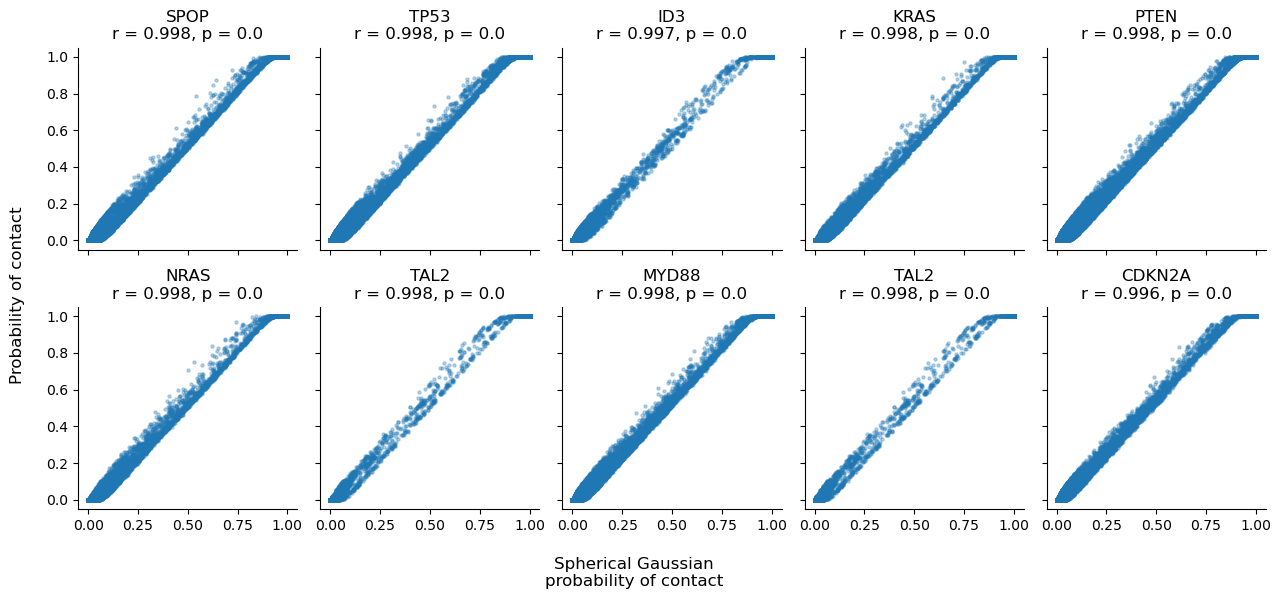

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

fig, axes = plt.subplots(2, 5, figsize=(13, 6), sharex=True, sharey=True)
axes = axes.flatten()

for ax, gene in zip(axes, genes):

    corr, elapsed_min = df[df["Gene"] == gene][["Corr", "Minutes"]].values[0]
    arr1 = pcmaps[gene]["pCMAP"].flatten()
    arr2 = pcmaps[gene]["Alt_pCMAP"].flatten()

    # arr1 = (arr1 > 0.5).astype(float)
    # arr2 = (arr2 > 0.5).astype(float)

    ax.scatter(arr2, arr1, alpha=0.3, s=5)
    ax.set_title(f"{gene}\nr = {corr:.3f}, Time = {elapsed_min} m")

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # ax.set_xlabel("pCMAP")
    # ax.set_ylabel("Alt_pCMAP")
    fig.supxlabel("Spherical Gaussian\nprobability of contact")
    fig.supylabel("Probability of contact\n")

plt.tight_layout()
plt.show()
